In [36]:
#First we extract all the landmarks using mediapipe. Then we save the landmarks
# in a file landmarks_file. The dataset is collected from https://www.kaggle.com/niharika41298
import os
import cv2
import pickle
import mediapipe as mp

def extract_pose_landmarks(dataset_dir):
    # Initialize MediaPipe pose detection
    mp_pose = mp.solutions.pose
    pose_detector = mp_pose.Pose(static_image_mode=True)
    
    landmark_data = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                # Read and process the image
                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = pose_detector.process(image_rgb)
                if results.pose_landmarks:
                    # Extract landmark coordinates
                    landmarks = results.pose_landmarks
                    coords = []
                    for landmark in landmarks.landmark:
                        coords.append((landmark.x, landmark.y, landmark.z))
                    landmark_data[image_path] = coords
                else:
                    print(f"No pose detected in {image_path}. Skipping...")

    pose_detector.close()
    return landmark_data

def save_landmark_data(landmark_data, output_file):
    # Save extracted landmarks to a file
    with open(output_file, 'wb') as f:
        pickle.dump(landmark_data, f)

# Main execution
dataset_dir = 'DATASET\TRAIN'
landmark_data = extract_pose_landmarks(dataset_dir)
print(f"len(landmark_data)={len(landmark_data)}, type(landmark_data)={type(landmark_data)}")
for k in landmark_data.keys():
    print(f"key={k}, value={landmark_data[k]}")
    break

landmarks_file = 'pose_landmarks.pkl'
save_landmark_data(landmark_data, landmarks_file)
print(f"File successfully saved to {landmarks_file}")

No pose detected in DATASET\TRAIN\downdog\00000147.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000168.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000173.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000188.png. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000220.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000221.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000224.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000232.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000235.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000239.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000270.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000281.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000300.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\00000304.jpg. Skipping...
No pose detected in DATASET\TRAIN\downdog\000003

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.95


<Figure size 1000x500 with 0 Axes>

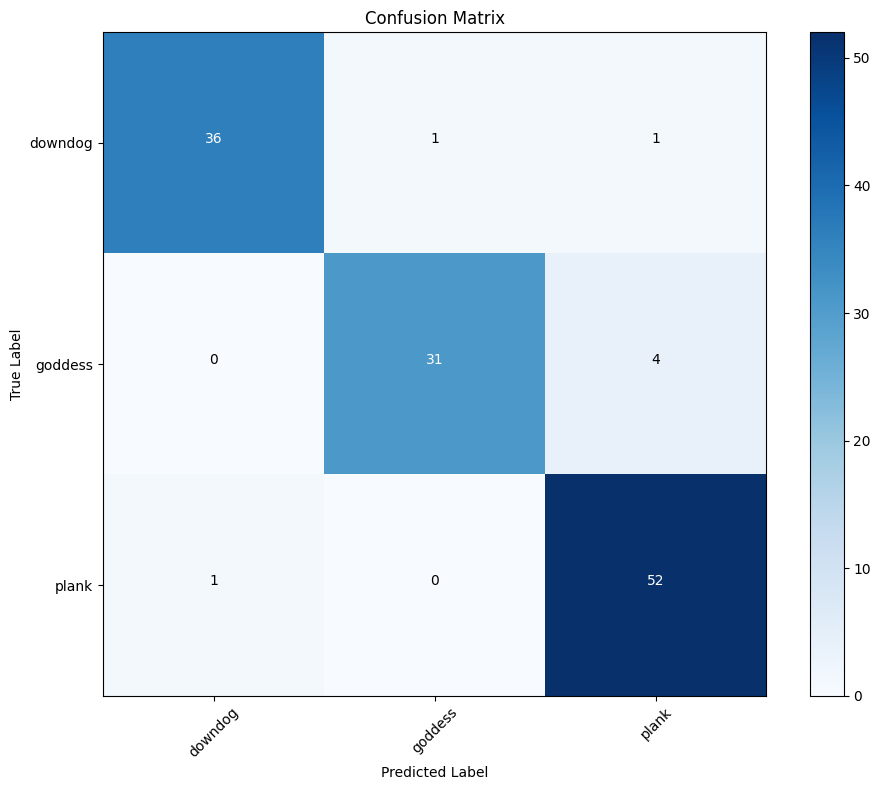

Classification Accuracy: 94.44%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        38
           1       0.97      0.89      0.93        35
           2       0.91      0.98      0.95        53

    accuracy                           0.94       126
   macro avg       0.95      0.94      0.94       126
weighted avg       0.95      0.94      0.94       126



In [37]:
#Now we find best classifer and save it.
#We also plot the metrics to see its performance

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from pathlib import Path

def load_landmark_data(file_path):
    # Load the saved landmark data
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def prepare_data(landmark_dict):
    # Convert landmark dictionary to numpy arrays
    data = []
    labels = []
    for img_path, landmarks in landmark_dict.items():
        data.append(np.array(landmarks).flatten())
        path = Path(img_path)
        # extract the label from the file path, i.e. 2nd from last
        labels.append(path.parts[-2])
    return np.asarray(data), np.asarray(labels)

def tune_classifier(x_train, y_train):
    # Define hyperparameters for grid search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # In a random forest classification, multiple decision trees are
    #created using different random subsets of the data and features. 
    #Each decision tree is like an expert, providing its opinion on how
    #to classify the data. Predictions are made by calculating the prediction
    #for each decision tree and then taking the most popular result.
    rf = RandomForestClassifier(random_state=42)

    # Perform grid search to find best hyperparameters
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    return grid_search.best_estimator_

def evaluate_classifier(model, x_test, y_test):
    # Evaluate the classifier and return metrics
    y_predict = model.predict(x_test)
    accuracy = accuracy_score(y_predict, y_test)
    report = classification_report(y_test, y_predict)
    matrix = confusion_matrix(y_test, y_predict)
    return accuracy, report, matrix

def plot_confusion_matrix(matrix, labels, title='Confusion Matrix'):
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
def display_metrics(matrix, labels, accuracy, report):
    # Display evaluation metrics
    plt.figure(figsize=(10,5))
    plot_confusion_matrix(matrix, labels)
    plt.show()
    print(f"Classification Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:\n", report)

def save_classifier(model, file_path):
    # Save the trained classifier
    with open(file_path, 'wb') as f:
        pickle.dump({'model': model}, f)

# Main execution
try:
    landmark_dict = load_landmark_data('pose_landmarks.pkl')
    data, labels = prepare_data(landmark_dict)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_
    x_train, x_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, shuffle=True, stratify=labels_encoded)

    best_classifier = tune_classifier(x_train, y_train)
    accuracy, report, matrix = evaluate_classifier(best_classifier, x_test, y_test)
    display_metrics(matrix, class_names, accuracy, report)
    save_classifier(best_classifier, 'pose_classifier.p')

except Exception as e:
    print("An error occurred:", str(e))


Predicting pose for image: 00000004.jpg


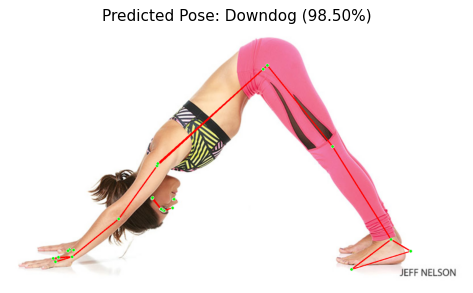


Predicting pose for image: 00000120.jpg
No pose detected in DATASET/TEST\downdog\00000120.jpg.

Predicting pose for image: 00000084.jpg


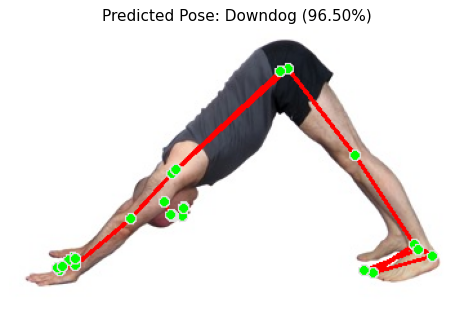


Predicting pose for image: 00000052.jpg


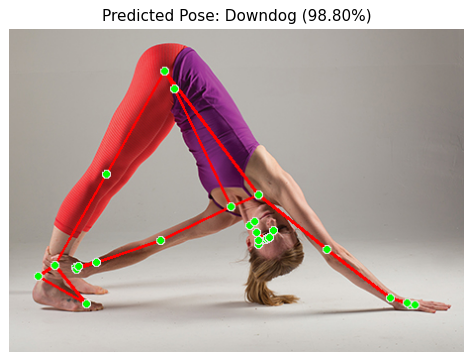


Predicting pose for image: 00000067.jpg


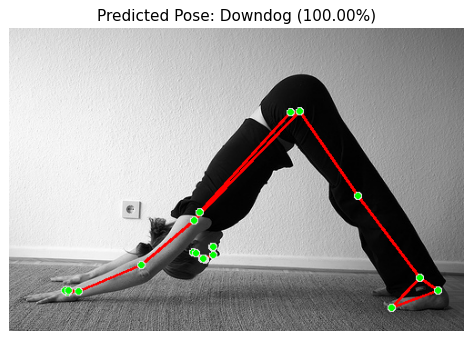


Predicting pose for image: 00000040.jpg


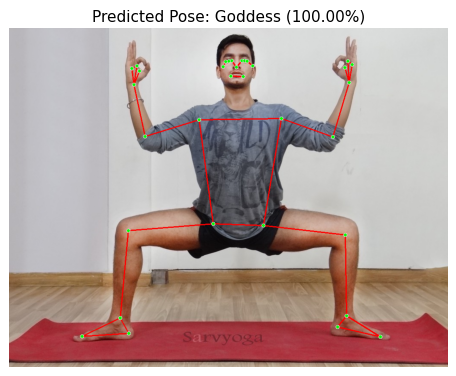


Predicting pose for image: 00000083.jpg


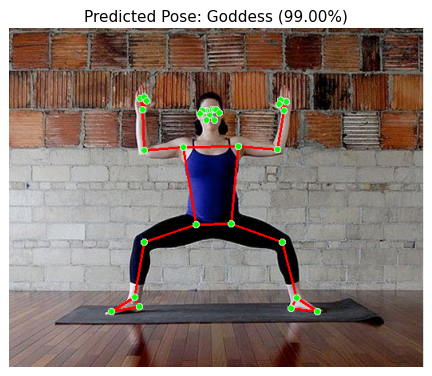


Predicting pose for image: 00000095.jpeg


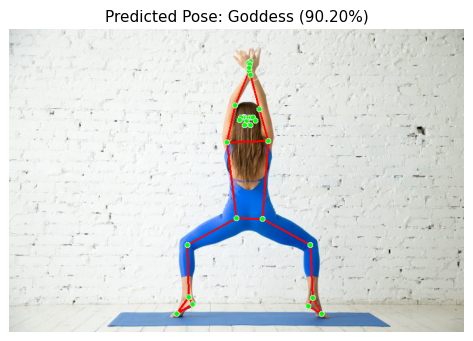


Predicting pose for image: 00000054.jpg


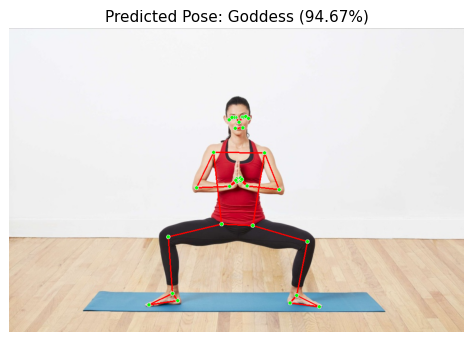


Predicting pose for image: 00000024.jpg


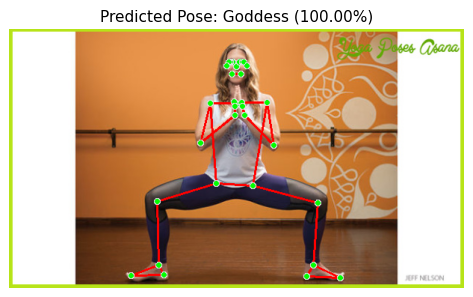


Predicting pose for image: 00000073.jpg


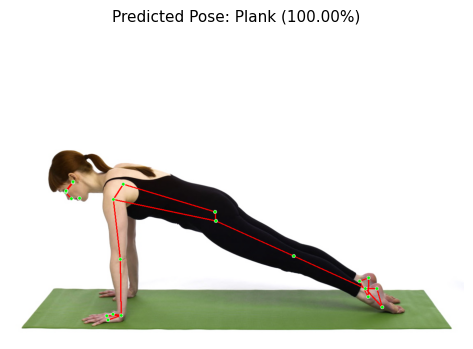


Predicting pose for image: 00000096.jpg


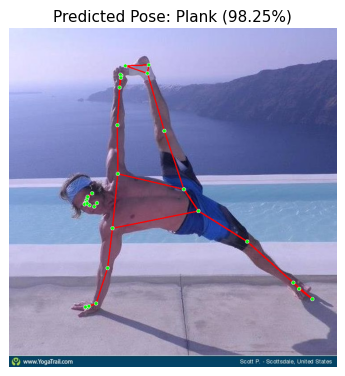


Predicting pose for image: 00000078.jpg


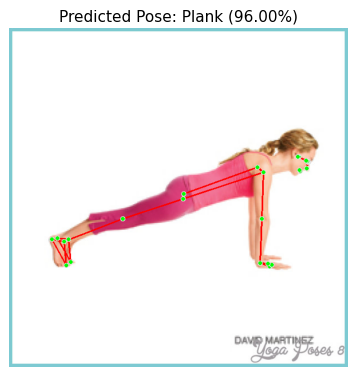


Predicting pose for image: 00000028.jpg


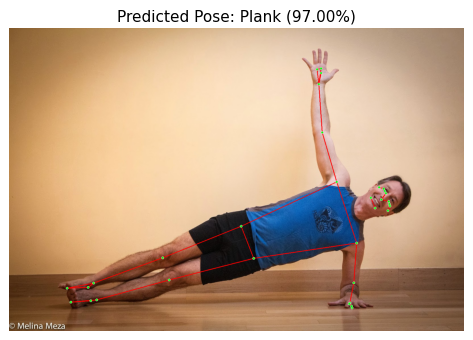


Predicting pose for image: 00000116.png


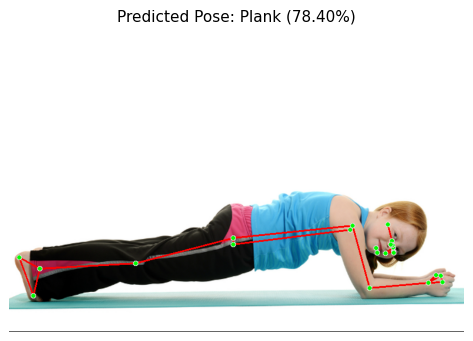

In [39]:
# Now we test it on a test data.

import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import os
import mediapipe as mp
import random
import warnings

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)

def load_classifier():
    # Load the trained classifier
    with open('pose_classifier.p', 'rb') as f:
        model_data = pickle.load(f)
    return model_data['model']

def initialize_pose_detector():
    # Initialize the MediaPipe pose detector
    return mp.solutions.pose.Pose(static_image_mode=True)

def predict_pose(img_path, classifier, pose_detector, class_names):
    # Predict pose for a given image
    img = cv2.imread(img_path)
    results = pose_detector.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
        print(f"No pose detected in {img_path}.")
        return

    img_with_pose = img.copy()

    # Extract landmark data
    landmark_data = []
    for landmark in results.pose_landmarks.landmark:
        x, y = int(landmark.x * img.shape[1]), int(landmark.y * img.shape[0])
        landmark_data.extend([landmark.x, landmark.y, landmark.z])

    # Make prediction
    prediction_index = classifier.predict([landmark_data])[0]
    predicted_class = class_names[prediction_index]
    confidence = np.max(classifier.predict_proba([landmark_data]))

    draw_landmarks(img_with_pose, results.pose_landmarks)
    display_prediction(img_with_pose, predicted_class, confidence)

def draw_landmarks(img, landmarks):
    # Draw pose landmarks on the image
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose

    mp_drawing.draw_landmarks(
        img,
        landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2)
    )

def display_prediction(img_with_pose, predicted_class, confidence):
    # Display the image with prediction results
    dpi = 550 / 6
    plt.figure(dpi=dpi)
    plt.imshow(cv2.cvtColor(img_with_pose, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Pose: {predicted_class.capitalize()} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

# Main execution
classifier = load_classifier()
pose_detector = initialize_pose_detector()
class_names = ['downdog', 'goddess', 'plank']

test_dataset = 'DATASET/TEST'

for class_name in os.listdir(test_dataset):
    class_dir = os.path.join(test_dataset, class_name)
    images = os.listdir(class_dir)
    
    # Randomly select 5 images from each folder in test directory
    selected_images = random.sample(images, min(5, len(images)))
    
    for image in selected_images:
        image_path = os.path.join(class_dir, image)
        print(f"\nPredicting pose for image: {image}")
        predict_pose(image_path, classifier, pose_detector, class_names)

In [2]:
# import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

video_path = '../temp/exercising.mp4' #'temp/running.mp4'

def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    # Initializing mediapipe pose class.
    mp_pose = mp.solutions.pose

    # Initializing mediapipe drawing class, useful for annotation.
    mp_drawing = mp.solutions.drawing_utils 
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

def detectPoseOnVideo(video=None):
    # Initializing mediapipe pose class.
    mp_pose = mp.solutions.pose

    # Setup Pose function for video.
    pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

    # Create named window for resizing purposes
    cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

    # Set video camera size
    video.set(3,1280)
    video.set(4,960)

    # Initialize a variable to store the time of the previous frame.
    time1 = 0

    # Iterate until the video is accessed successfully.
    while video.isOpened():
        
        # Read a frame.
        ok, frame = video.read()
        
        # Check if frame is not read properly.
        if not ok:
            break # Break the loop.
        
        # Flip the frame horizontally for natural (selfie-view) visualization.
        frame = cv2.flip(frame, 1)
        
        # Get the width and height of the frame
        frame_height, frame_width, _ =  frame.shape
        
        # Resize the frame while keeping the aspect ratio.
        frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
        
        # Perform Pose landmark detection.
        frame, _ = detectPose(frame, pose_video, display=False)
        
        # Set the time for this frame to the current time.
        time2 = time()
        
        # Check if the difference between the previous and this frame time > 0 to avoid division by zero.
        if (time2 - time1) > 0:
        
            # Calculate the number of frames per second.
            frames_per_second = 1.0 / (time2 - time1)
            
            # Write the calculated number of frames per second on the frame. 
            cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
        
        # Update the previous frame time to this frame time.
        # As this frame will become previous frame in next iteration.
        time1 = time2
        
        # Display the frame.
        cv2.imshow('Pose Detection', frame)
        
        # Wait until a key is pressed.
        # Retreive the ASCII code of the key pressed
        k = cv2.waitKey(1) & 0xFF
        
        # Check if 'ESC' is pressed.
        if(k == 27):
            
            # Break the loop.
            break

    # Release the VideoCapture object.
    video.release()

    # Close the windows.
    cv2.destroyAllWindows()
    
#MAIN execution
# Initialize the VideoCapture object to read from the webcam.
# video = cv2.VideoCapture(1)

# Initialize the VideoCapture object to read from a video stored in the disk.
video = cv2.VideoCapture(video_path) 
detectPoseOnVideo(video=video)
        
    
